In [102]:
#by Prof. Josenalde Oliveira Jan 2022

#FOPTD methods Ziegler-Nichols inflection point
#https://pypi.org/project/mat4py/#files
!pip install mat4py

from mat4py import loadmat
# file from https://github.com/rwguerra/classic_identification_FOPDT/blob/master/dados.mat
# https://towardsai.net/p/engineering/classic-methods-for-identification-of-first-order-plus-dead-time-fopdt-systems?amp=1
data = loadmat('dados.mat')
print(data['y'])
#data is a dict

[[10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [11.363550678677955], [15.645803028791352], [19.551019525220166], [23.112396725135973], [26.360208356495896], [29.322062661916327], [32.023137084408106], [34.48639228993504], [36.73276734610921], [38.781357716152506], [40.649577581174334], [42.35330787059692], [43.907031259070834], [45.323955277431146], [46.61612458420737], [47.79452335205856], [48.86916863947653], [49.849195541469584], [50.742934843056034], [51.55798383566615], [52.301270898432165], [52.97911439334417], [53.597276374913804], [54.161011570908705], [54.675112050521626], [55.14394795967891], [55.57150466976181], [55.96141665552564], [56.31699839019849], [56.64127252038525], [56.93699556027964], [57.206681323599746], [57.45262229243166], [57.67690910462868], [57.88144832541982], [58.06797865429665], [58.238085704946016], [58.39321548386649], [58.53

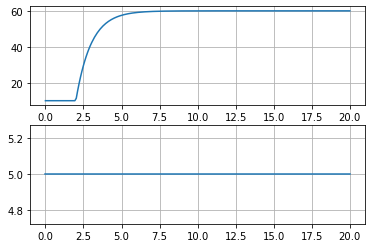

In [12]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(data['t'], data['y']) #data[.] of list type
plt.grid()
plt.subplot(2,1,2)
plt.plot(data['t'], data['u'])
plt.grid()

1.9927066631319779
0.8202849760255173
9.999999847700202


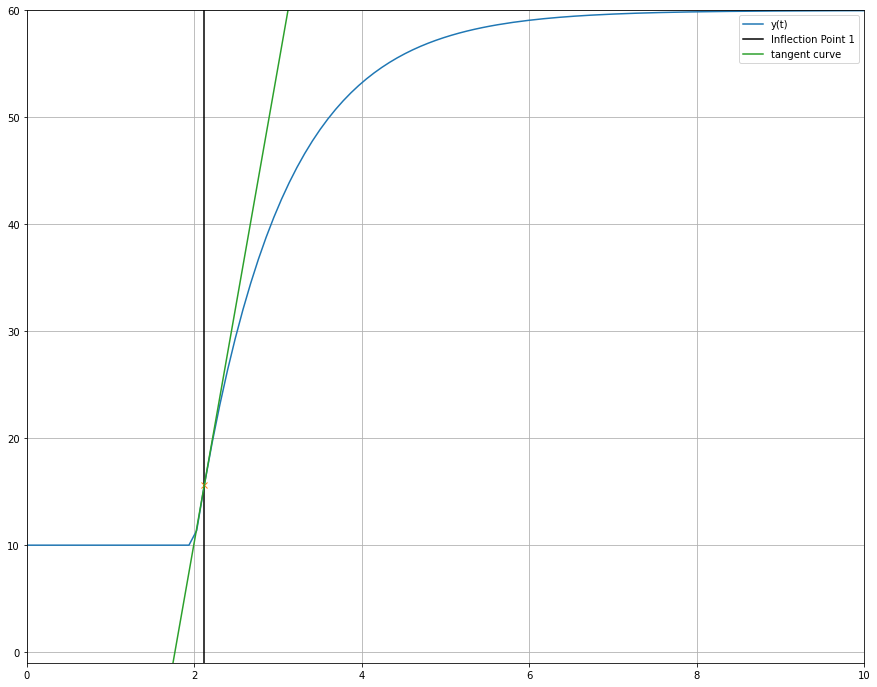

In [145]:
import numpy as np

init = 20
#len(data['y']) # 218 points
y_array = np.array(data['y'], dtype=float)
#print(y_array.T)
t_array = np.array(data['t'], dtype=float)
#print(t_array[:,0])
# first derivative
d_data_f = np.gradient(y_array[:,0], t_array[:,0], axis=0) #t_array[:,0] is the spacing 1D
d_data = np.gradient(y_array[init:,0], t_array[init:,0], axis=0) #t_array[:,0] is the spacing 1D
# second derivative
d_d_data = np.gradient(d_data)

# inflection point
if_p = np.where(np.diff(np.sign(d_d_data)))[0]
#print(np.diff(np.sign(d_d_data)))
#print(if_p) #fourth point after delay

plt.figure(figsize=(15,12))
plt.plot(t_array, y_array, label='y(t)')
#plt.plot(t_array[init:,0], d_data,label='dydt')
#plt.plot(t_array[init:,0],d_d_data, label='d(dydt)')
plt.axvline(x=t_array[init+if_p], color='k', label=f'Inflection Point {1}')


#print(d_data.size)
#print(t_array[20:,0].size)

#MATLAB
#t_infl = interp1(d1y(21:end), t(21:end), max(d1y));             % Find ‘t’ At Maximum Of First Derivative
#y_infl = interp1(t(21:end), y(21:end), t_infl);

# (y - y1) = m(x - x1)
#m slope

m = d_data[if_p]
#print(m)

# y = y1 + m(x - x1)
tan_eq = y_array[init+if_p] + m*(t_array[:,0] - t_array[init+if_p])

#print(tan_eq)
plt.plot(t_array[init+if_p], y_array[init+if_p], marker='x')

plt.plot(t_array[:,0], tan_eq[0], label='tangent curve')
plt.axis([0, 10, -1, 60])
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid()

#delay
theta = np.interp(10, tan_eq[0], t_array[:,0])
print(theta)
#time constant
#print(0.63*max(y_array[:,0]))
tau = np.interp(0.63*max(y_array[:,0]), y_array[:,0], t_array[:,0]) - theta
print(tau)
#gain
delta_y = max(y_array[:,0]) - min(y_array[:,0])
u_array = np.array(data['u'], dtype=float)
#print(u_array)
delta_u = max(u_array) - 0;
K = delta_y / delta_u
print(K)


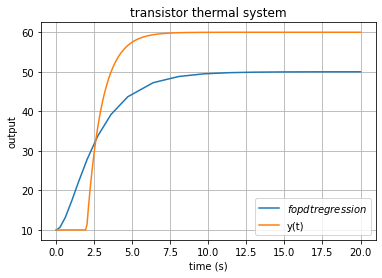

Wall time: 180 ms


In [148]:
%%time
"""
Seja kp = ganho
     teta_p = atraso
     tau_p = constante de tempo
     y/u = a / (bs^2+cs+1)
     onde a = kp, b = tau_p*theta_p e c =(theta_p + tau_p)
     Por Prof. Josenalde Oliveira - Sistemas Embarcados TADS UFRNt
"""
def fopdt_temp(time,X,kp,tau_p,theta_p,u):
    a = kp
    b = tau_p*theta_p
    c = (theta_p + tau_p)
    x1,x2 = X
    dotx1 = x2
    dotx2 = (1/b)*(-c*x2-x1+a*u) # u = força externa / sinal de controle
    return dotx1, dotx2

ti = 0
tf = 20
x10,x20=10,0 #assume que a mola esta em repouso x = 0, v = 0

# método de solução de ode Runge-Kutta implícito de ordem 5 RADAU
from scipy import integrate
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

#regression model temp system
kp = K
tau_p = tau
theta_p = theta

sol1 = integrate.solve_ivp(fopdt_temp, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(kp,tau_p,theta_p,5))
t1, Y1 = sol1.t, sol1.y

# Separando as soluções y1 é y, y2 é dot_y
y1_pos, y1_vel = Y1 # y1 posicao, y2 velocidade

plt.figure(1)
plt.plot(t1, y1_pos, label=r'$fopdt regression$')
plt.plot(t_array, y_array, label='y(t)')
plt.legend()
plt.xlabel('time (s)')
plt.title('transistor thermal system')
plt.ylabel('output')
plt.grid()
plt.show()

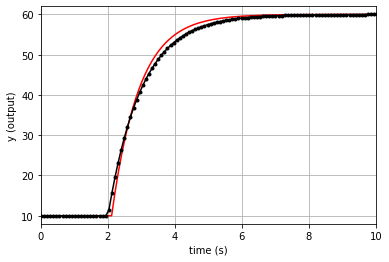

61.3411872385924


In [163]:
######################################################
# FOPDT model                                        #
######################################################
Kp = K      # degC/%
tauP = tau  # seconds
thetaP = theta   # seconds (integer)
Tss = 10      # degC (ambient temperature)
Qss = 0       # % heater
dt = 0.1 #1s
Tpl = []
Tpl.append(10) # primeira temperatura lida, assumindo ser a ambiente TSS
i = 1
tMax = 20
nSamples = tMax/dt
# Simulate one time step with linear FOPDT model
z = np.exp(-dt/tauP)
Q1 = np.ones(int(nSamples)) * 0
Q1[20:] = 5.0
while (i <= nSamples):
    Tpl.append((Tpl[i-1]-Tss) * z + (Q1[max(0, i-int(thetaP)-1)]-Qss)*(1-z)*Kp + Tss)      
    i += 1

time = np.linspace(0, tMax, int(nSamples))
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(time, Tpl[0:len(time)], color='r')
plt.plot(t_array, y_array, marker='.', color='k', label='y(t) measured')
plt.axis([0,10,8,62])
plt.xlabel('time (s)')
plt.ylabel('y (output)')
plt.grid()
plt.show()

mape = np.mean((abs(Tpl-y_array))/(y_array)*100)

print(mape)